/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5124 - loss: 0.6938 - val_accuracy: 0.5376 - val_loss: 0.6887
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6011 - loss: 0.6537 - val_accuracy: 0.6092 - val_loss: 0.6321
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6315 - loss: 0.6044 - val_accuracy: 0.6400 - val_loss: 0.6399
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6967 - loss: 0.5608 - val_accuracy: 0.7486 - val_loss: 0.5331
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8196 - loss: 0.3999 - val_accuracy: 0.8466 - val_loss: 0.3594
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9224 - loss: 0.2129 - val_accuracy: 0.8538 - val_loss: 0.3658
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9531 - loss: 0.1415 - val_accuracy: 0.8552 - val_loss: 0.4009
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9685 - loss: 0.1048 - val_accu

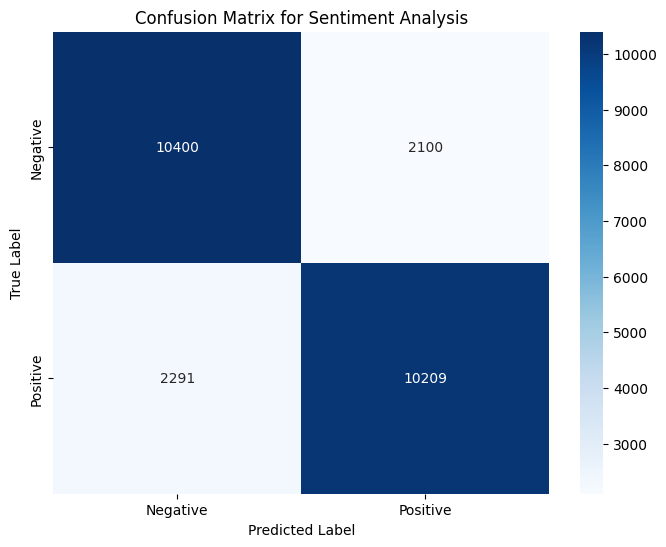


Confusion Matrix Metrics:
Accuracy : 0.8244
Precision: 0.8294
Recall   : 0.8167
F1-Score : 0.8230
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model and tokenizer saved successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

Sentiment Analysis Results (After Propagation):
Node 1: Text='This movie was absolutely fantastic! Great acting and a gripping story.', Sentiment='positive'
Node 2: Text='I was so disappointed by this film. It was slow and boring.', Sentiment='negative'
Node 3: Text='The cinematography was stunning, but the plot felt predictable.', Sentiment='negative'
Node 4: Text='An incredible experience! I loved every minute of this movie.', Sentiment='positive'
Node 5: Text='The movie dragged on and lacked any real excitement.', Sentiment='negative'
Node 6: Text='A masterpiece! The characters were so well-developed.', Sentiment='positive'

Edges (Similarity Relationships):
Edge 2–5: Similarity=0.71


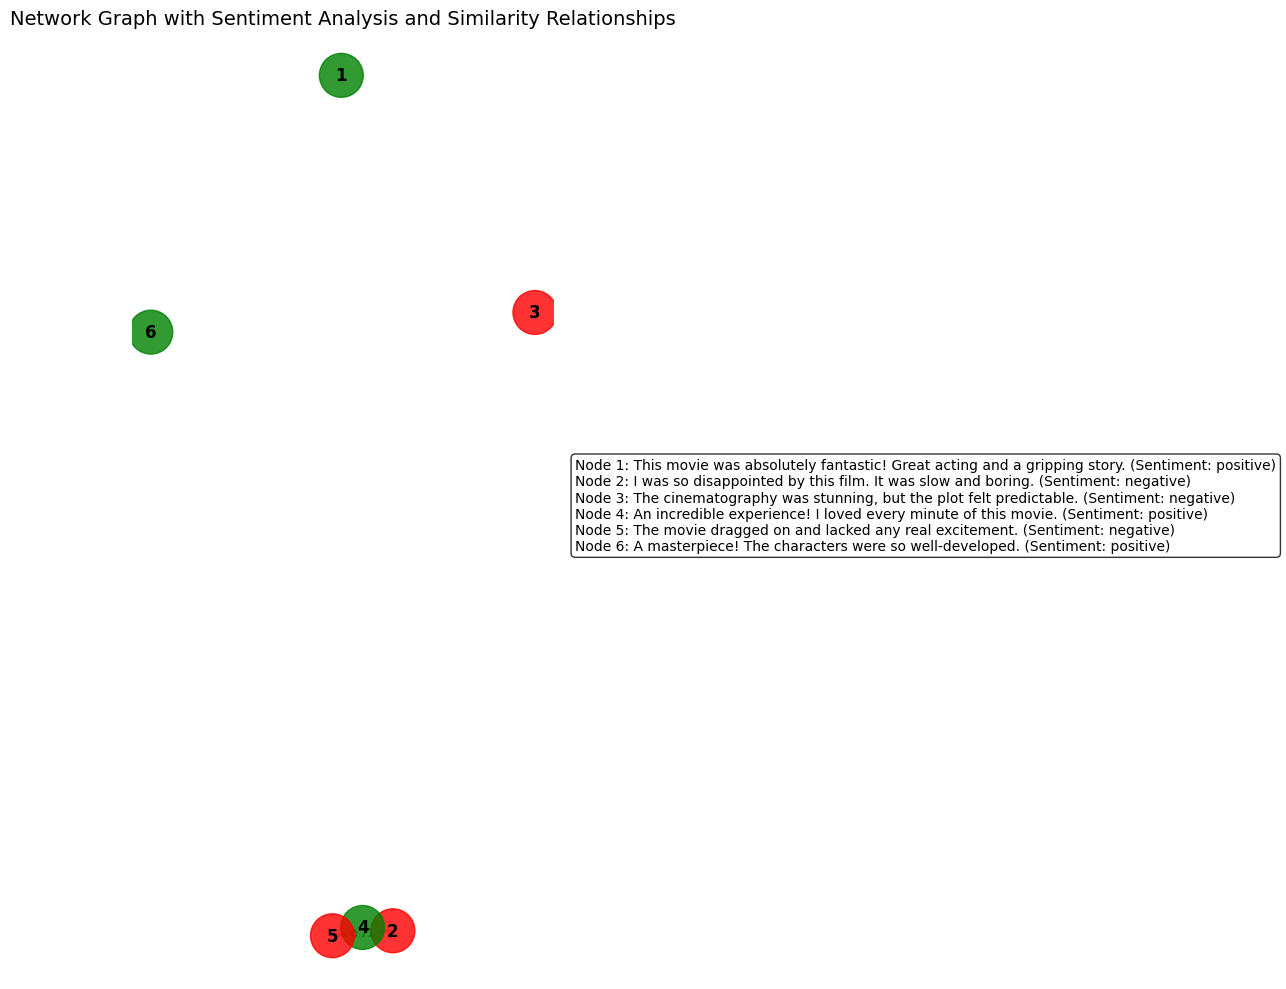

In [ ]:
import pandas as pd
import networkx as nx
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.datasets import imdb
import pickle
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Hyperparameters
vocab_size = 10000
max_length = 200
embedding_dim = 128
lstm_units = 128
epochs = 10  # Increased for better training
batch_size = 64

# Step 1: Load and preprocess IMDB data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size, skip_top=0, maxlen=None, start_char=1, oov_char=2, index_from=3)
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

# Step 2: Build the model with LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(units=lstm_units),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Step 3: Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Step 4: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Step 4.2: Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()

# Print Confusion Matrix metrics
TN, FP, FN, TP = conf_matrix.ravel()
accuracy_cm = (TP + TN) / (TP + TN + FP + FN)
precision_cm = TP / (TP + FP)
recall_cm = TP / (TP + FN)
f1_score_cm = 2 * (precision_cm * recall_cm) / (precision_cm + recall_cm)
print("\nConfusion Matrix Metrics:")
print(f"Accuracy : {accuracy_cm:.4f}")
print(f"Precision: {precision_cm:.4f}")
print(f"Recall   : {recall_cm:.4f}")
print(f"F1-Score : {f1_score_cm:.4f}")

# Step 5: Save the model
model.save('sentiment_rnn_model.h5')

# Step 6: Save the tokenizer
word_index = imdb.get_word_index()
# Adjust word index for IMDB's offset
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
tokenizer.word_index = word_index
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)
print("Model and tokenizer saved successfully!")

# Step 7: Sentiment Analysis on Graph
def perform_sentiment_analysis(graph, model_path, tokenizer_path, max_length):
    try:
        # Extract texts from nodes
        texts = [data['text'] for node, data in graph.nodes(data=True) if 'text' in data]
        if not texts:
            raise ValueError("No 'text' attributes found in the graph nodes.")

        # Load tokenizer
        with open(tokenizer_path, 'rb') as handle:
            tokenizer = pickle.load(handle)

        # Preprocess texts
        sequences = tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

        # Load model
        model = load_model(model_path)

        # Predict sentiments
        predictions = model.predict(padded_sequences)
        sentiments = ['positive' if p > 0.5 else 'negative' for p in predictions.flatten()]

        # Attach sentiments to nodes
        text_idx = 0
        for node, data in graph.nodes(data=True):
            if 'text' in data:
                graph.nodes[node]['sentiment'] = sentiments[text_idx]
                text_idx += 1

        return graph
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Could not find model or tokenizer file: {e}")
    except Exception as e:
        raise Exception(f"Error in sentiment analysis: {e}")

# Step 8: Add similarity-based edges
def get_text_embeddings(texts):
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    embeddings = embed(texts)
    return np.array(embeddings)

def add_similarity_edges(G, similarity_threshold=0.7):  # Increased threshold for fewer, stronger edges
    texts = [data['text'] for _, data in G.nodes(data=True)]
    embeddings = get_text_embeddings(texts)
    similarity_matrix = cosine_similarity(embeddings)

    for i, node_i in enumerate(G.nodes):
        for j, node_j in enumerate(G.nodes):
            if i < j:
                similarity = similarity_matrix[i, j]
                if similarity > similarity_threshold:
                    G.add_edge(node_i, node_j, weight=similarity, label=f"{similarity:.2f}")
    return G

# Step 9: Sentiment Propagation (Simple majority voting based on neighbors)
def propagate_sentiments(G):
    updated_graph = G.copy()
    for node in updated_graph.nodes:
        neighbors = list(updated_graph.neighbors(node))
        if neighbors:
            neighbor_sentiments = [updated_graph.nodes[n]['sentiment'] for n in neighbors]
            positive_count = sum(1 for s in neighbor_sentiments if s == 'positive')
            negative_count = len(neighbor_sentiments) - positive_count
            # Update sentiment based on majority
            updated_graph.nodes[node]['sentiment'] = 'positive' if positive_count > negative_count else 'negative'
    return updated_graph

# Example Usage
if __name__ == "__main__":
    # Create a sample graph with diverse movie reviews
    G = nx.Graph()
    nodes = [
        (1, {"text": "This movie was absolutely fantastic! Great acting and a gripping story."}),
        (2, {"text": "I was so disappointed by this film. It was slow and boring."}),
        (3, {"text": "The cinematography was stunning, but the plot felt predictable."}),
        (4, {"text": "An incredible experience! I loved every minute of this movie."}),
        (5, {"text": "The movie dragged on and lacked any real excitement."}),
        (6, {"text": "A masterpiece! The characters were so well-developed."}),
    ]
    G.add_nodes_from(nodes)

    model_path = 'sentiment_rnn_model.h5'
    tokenizer_path = 'tokenizer.pickle'

    try:
        # Perform sentiment analysis
        G_with_sentiments = perform_sentiment_analysis(G, model_path, tokenizer_path, max_length)
        # Add similarity edges
        G_with_edges = add_similarity_edges(G_with_sentiments)
        # Propagate sentiments
        G_final = propagate_sentiments(G_with_edges)

        # Print results
        print("\nSentiment Analysis Results (After Propagation):")
        for node in G_final.nodes(data=True):
            print(f"Node {node[0]}: Text='{node[1]['text']}', Sentiment='{node[1]['sentiment']}'")

        print("\nEdges (Similarity Relationships):")
        for edge in G_final.edges(data=True):
            print(f"Edge {edge[0]}–{edge[1]}: Similarity={edge[2]['weight']:.2f}")

        # Visualize the network graph
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G_final, k=0.9, iterations=100)  # Improved layout
        node_colors = ['green' if G_final.nodes[n]['sentiment'] == 'positive' else 'red' for n in G_final.nodes]
        node_sizes = [1000 for _ in G_final.nodes]

        # Draw nodes
        nx.draw_networkx_nodes(G_final, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
        # Draw node labels (just node IDs)
        nx.draw_networkx_labels(G_final, pos, labels={n: str(n) for n in G_final.nodes}, font_size=12, font_weight='bold')
        # Draw edges
        edge_weights = [G_final[u][v]['weight'] * 3 for u, v in G_final.edges()]
        nx.draw_networkx_edges(G_final, pos, width=edge_weights, edge_color='gray', alpha=0.6)
        # Draw edge labels
        edge_labels = nx.get_edge_attributes(G_final, 'label')
        nx.draw_networkx_edge_labels(G_final, pos, edge_labels=edge_labels, font_size=8)

        # Add legend
        legend_labels = {n: f"Node {n}: {G_final.nodes[n]['text']} (Sentiment: {G_final.nodes[n]['sentiment']})" for n in G_final.nodes}
        plt.text(1.05, 0.5, '\n'.join(legend_labels.values()), transform=plt.gca().transAxes, fontsize=10, verticalalignment='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.title("Network Graph with Sentiment Analysis and Similarity Relationships", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    except FileNotFoundError as e:
        print(f"Error: Could not find model or tokenizer file. {e}")
    except Exception as e:
        print(f"An error occurred: {e}")